# LIBRARIES

In [3]:
import catboost as cb
import utils.config
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
import logging
import matplotlib.pyplot as plt
from model import model_train
import numpy as np
import optuna
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy.stats import skew
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## LOGGING

In [2]:
# preparing logging
logging.basicConfig(filename=config.LOG_FILES_TRAIN,
                    level=logging.INFO,
                    filemode='a',
                    format='%(asctime)s %(levelname)s %(name)s  %(message)s')
logger = logging.getLogger()

## LOAD DATASET

In [3]:
# Load Dataset
logger.info('Reading in dataset')
df = pd.read_csv(config.TRAINING_FILE, sep=';', index_col='id')
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
988,22469,1,155,69.0,130,80,2,2,0,0,1,0
989,14648,1,163,71.0,110,70,1,1,0,0,1,1
990,21901,1,165,70.0,120,80,1,1,0,0,1,0
991,14549,2,165,85.0,120,80,1,1,1,1,1,0
992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [4]:
# Summary of the dataset
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000,69301.000000
mean,19468.786280,1.349519,164.362217,74.203027,128.829584,96.650092,1.366806,1.226447,0.088051,0.053881,0.803986,0.499589
std,2467.261818,0.476821,8.205337,14.383469,154.775805,189.096240,0.680270,0.572246,0.283371,0.225784,0.396982,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19704.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21326.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


## CORRELATION HEATMAP

<AxesSubplot:>

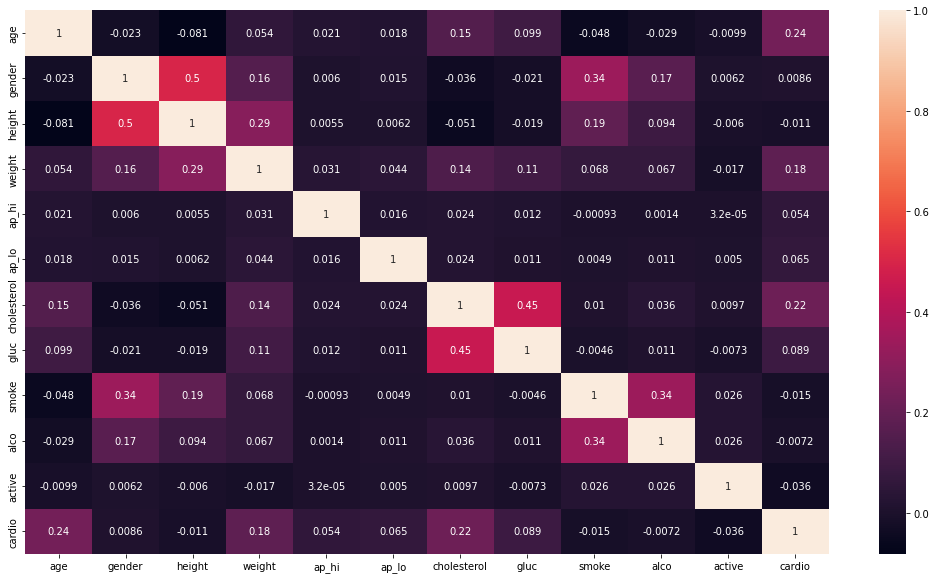

In [5]:
plt.figure(figsize=(18,10))
sns.heatmap(df.corr(),annot=True)

## DATA PRE-PROCESSING

 1. CONVERT AGE FROM DAYS TO YEARS


In [6]:
age_year = df['age'].apply(lambda x: x/365)
df['age'] = np.ceil(age_year)
logger.info('Successfully converted age from days to years')

2. RENAME API_HI AND AP_LO TO MORE RELATABLE NAMES


In [7]:
df.rename(columns={"ap_hi": "systolic_pressure", "ap_lo": "diastolic_pressure"},inplace=True)
print('Successfully rename columns to systolic_pressure and diastolic pressure')

Successfully rename columns to systolic_pressure and diastolic pressure


## INFERENCES  


The dataset contains adults ranging from 30 - 65 years of age, therefore we can make some assumptions to treat outliers.


1. Min height in the dataset is 55cm, Max height 250cm

        We will assume the lower limit to be 140cm and upper limit to be 185cm.

2. Min weight in the dataset is 10kg, Max weight 200kg

        We will assume the lower limit to be 45kg and upper limit to be 130 kg.

3. Systolic pressure ranges from 90mm/Hg to 120mm/Hg according to scientific publications
        https://www.medicinenet.com/blood_pressure_chart_reading_by_age/article.htm.

        We will assume the lower limit as 90mm/Hg and upper limit to 180mm/Hg to accomodate for hypertensive participants

 4. Diastolic pressure ranges from 60mm/Hg to 80mm/Hg according to scientific publications.

        We will assume the lower limit as 60mm/Hg and upper limit to 120mm/Hg to accomodate or hypertensive participants

5. Convert negative systolic and diastolic blood pressure by multiplying it by -1


## FEATURE ENGINEERING

 1. CONVERTING NEGATIVE API_HI AND AP_LO VALUES

In [9]:
df.loc[(df['systolic_pressure'] < 0), "systolic_pressure"].apply(lambda x: (x*-1))
df.loc[(df['diastolic_pressure'] < 0), "diastolic_pressure"].apply(lambda x: (x*-1))

id
85816    70
Name: diastolic_pressure, dtype: int64

 2. CONVERTING OUTLIER VALUES TO NAN

In [10]:
df.loc[(df['systolic_pressure'] < 90) | (df['systolic_pressure'] > 180), "systolic_pressure"] = np.nan
df.loc[(df['diastolic_pressure'] < 60) | (df['diastolic_pressure'] > 120), "diastolic_pressure"] = np.nan
df.loc[(df['weight'] < 60) | (df['weight'] > 120), "weight"] = np.nan
df.loc[(df['height'] < 120) | (df['height'] > 192), "height"] = np.nan

3. DROP NAN VALUES

In [11]:
df_transformed = df.dropna()
df_transformed.shape

(59138, 12)

# MODEL TRAINING

1. SPILT DATASET INTO TRAINING AND TESTING

In [12]:
# target
target = df_transformed.cardio
# transformed dataset
df_train = df_transformed.drop(['cardio'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_train, target, test_size=0.30, random_state=42)

2. Baseline Models

In [13]:
model_train(df_train=X_train,target=y_train)

Logistic Regession: The F1_score is 0.7058795071738841
Random Forest Classifier: The F1_score is 0.7095315236999609
Support Vector Clasifier: The F1_score is 0.6946819715675524
K-Nearest Neighbour: The F1_score is 0.683543832398824
Catboost: The F1_score is 0.7251892868462019
XGBoost: The F1_score is 0.7185513195008997


3. Baseline Models + Scaling

In [18]:
rb_scl = RobustScaler()

# scale numerical colums
X_train[['age', 'gender', 'height', 'weight', 'systolic_pressure',
       'diastolic_pressure']] = rb_scl.fit_transform(X_train[['age', 'gender', 'height', 'weight', 'systolic_pressure',
       'diastolic_pressure']])


model_train(df_train= X_train, target=y_train)

Logistic Regession: The F1_score is 0.7158793804009574
Random Forest Classifier: The F1_score is 0.7098726338916882
Support Vector Clasifier: The F1_score is 0.7177367447221359
K-Nearest Neighbour: The F1_score is 0.6958058844824276
Catboost: The F1_score is 0.7251892868462019
XGBoost: The F1_score is 0.7185690113186122


4. Baseline Models + Feature Selection

In [20]:
# select the top 5 features for our model.

extra_clf = ExtraTreesClassifier()
extra_clf.fit(X_train, y_train)
feature_importance = pd.Series(extra_clf.feature_importances_, index=X_train.columns)
best_feature = feature_importance.nlargest(5)
feature_index = best_feature.index
X_train = X_train.filter(items=list(feature_index), axis=1)

In [21]:
print('The selected columns are:')
for col_name in X_train.columns:
    print(col_name)


The selected columns are:
height
weight
systolic_pressure
age
diastolic_pressure


In [23]:
model_train(df_train=X_train, target=y_train)

Logistic Regession: The F1_score is 0.7090167958999493
Random Forest Classifier: The F1_score is 0.6801226032418092
Support Vector Clasifier: The F1_score is 0.7073608915136012
K-Nearest Neighbour: The F1_score is 0.6821868992268332
Catboost: The F1_score is 0.713928929247285
XGBoost: The F1_score is 0.706195228951862


# HYPER PARAMETER TUNING

https://www.kaggle.com/saurabhshahane/catboost-hyperparameter-tuning-with-optuna?cellIds=9&kernelSessionId=81896312

In [24]:
def objective(trial):
    # train_x, valid_x, train_y, valid_y = train_test_split(df_train,target, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb_clf = cb.CatBoostClassifier(**param)

    score = cross_val_score(cb_clf, X_train, y_train, n_jobs=-1, cv=3, scoring='f1')
    f1_score= score.mean()

    # gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0)

    # preds = gbm.predict(valid_x)
    # pred_labels = np.rint(preds)
    # accuracy = f1_score(valid_y, pred_labels)
    return f1_score

In [25]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-01-05 00:29:52,123] A new study created in memory with name: no-name-2b7758a5-0c5b-4154-91ac-7b24028b836b
[I 2023-01-05 00:30:20,328] Trial 0 finished with value: 0.6876634573746389 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.03118486777497701, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.287230270426491}. Best is trial 0 with value: 0.6876634573746389.
[I 2023-01-05 00:30:37,934] Trial 1 finished with value: 0.7078314546299032 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09638913668554346, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.850294964734916}. Best is trial 1 with value: 0.7078314546299032.
[I 2023-01-05 00:31:06,351] Trial 2 finished with value: 0.7062233263457065 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09221720785074707, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.86

In [26]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.7099687124705881
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09259139254392691
    depth: 10
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.5783163167640492


### Re-train the Model

In [27]:
param = {
    'objective': 'Logloss',
    'colsample_bylevel': 0.09259139254392691,
    'depth': 10,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.5783163167640492
}


cb_clf_final = cb.CatBoostClassifier(**param)
cb_clf_final.fit(X_train,y_train)


Learning rate set to 0.05051
0:	learn: 0.6931155	total: 161ms	remaining: 2m 40s
1:	learn: 0.6930957	total: 167ms	remaining: 1m 23s
2:	learn: 0.6930734	total: 173ms	remaining: 57.4s
3:	learn: 0.6930536	total: 179ms	remaining: 44.6s
4:	learn: 0.6831457	total: 191ms	remaining: 37.9s
5:	learn: 0.6831237	total: 200ms	remaining: 33.1s
6:	learn: 0.6831132	total: 206ms	remaining: 29.3s
7:	learn: 0.6814606	total: 213ms	remaining: 26.4s
8:	learn: 0.6806643	total: 222ms	remaining: 24.4s
9:	learn: 0.6806545	total: 228ms	remaining: 22.6s
10:	learn: 0.6806427	total: 234ms	remaining: 21.1s
11:	learn: 0.6806377	total: 240ms	remaining: 19.8s
12:	learn: 0.6806355	total: 246ms	remaining: 18.7s
13:	learn: 0.6806222	total: 255ms	remaining: 18s
14:	learn: 0.6798401	total: 263ms	remaining: 17.3s
15:	learn: 0.6798322	total: 272ms	remaining: 16.7s
16:	learn: 0.6798288	total: 280ms	remaining: 16.2s
17:	learn: 0.6742526	total: 288ms	remaining: 15.7s
18:	learn: 0.6661589	total: 297ms	remaining: 15.3s
19:	learn: 0

### Process test  set

In [29]:
X_test[['age', 'gender', 'height', 'weight', 'systolic_pressure',
       'diastolic_pressure']] = rb_scl.fit_transform(X_test[['age', 'gender', 'height', 'weight', 'systolic_pressure',
       'diastolic_pressure']])

In [30]:
extra_clf = ExtraTreesClassifier()
extra_clf.fit(X_test, y_test)
feature_importance = pd.Series(extra_clf.feature_importances_, index=X_test.columns)
best_feature = feature_importance.nlargest(5)
feature_index = best_feature.index
X_test = X_test.filter(items=list(feature_index), axis=1)

In [31]:
print('The selected columns on the test dataset are:')
for col_name in X_test.columns:
    print(col_name)


The selected columns on the test dataset are:
height
weight
age
systolic_pressure
diastolic_pressure


In [32]:
pred = cb_clf_final.predict(X_test)

print('the f1 score is {}'.format(f1_score(y_test, pred)))

the f1 score is 0.7028972885095511


Implementing keras model

In [51]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(5,)),
    keras.layers.Dense(512,activation=tf.nn.relu),
	keras.layers.Dense(128,activation=tf.nn.relu),
    keras.layers.Dense(32,activation=tf.nn.relu),
    keras.layers.Dense(16,activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])


In [48]:
def get_f1(y_true, y_pred):
    """
    custom f1 metric
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [52]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[get_f1])

model.fit(X_train, y_train, epochs=50, batch_size=128)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test F1 score:', test_acc)

Epoch 1/50
324/324 [==============================] - 3s 6ms/step - loss: 0.5707 - get_f1: 0.7116
Epoch 2/50
324/324 [==============================] - 2s 7ms/step - loss: 0.5637 - get_f1: 0.7139
Epoch 3/50
324/324 [==============================] - 2s 6ms/step - loss: 0.5623 - get_f1: 0.7136
Epoch 4/50
324/324 [==============================] - 2s 7ms/step - loss: 0.5619 - get_f1: 0.7137
Epoch 5/50
324/324 [==============================] - 2s 7ms/step - loss: 0.5614 - get_f1: 0.7124
Epoch 6/50
324/324 [==============================] - 2s 7ms/step - loss: 0.5605 - get_f1: 0.7135
Epoch 7/50
324/324 [==============================] - 3s 8ms/step - loss: 0.5599 - get_f1: 0.7139
Epoch 8/50
324/324 [==============================] - 2s 7ms/step - loss: 0.5598 - get_f1: 0.7135
Epoch 9/50
324/324 [==============================] - 3s 9ms/step - loss: 0.5597 - get_f1: 0.7148
Epoch 10/50
324/324 [==============================] - 3s 8ms/step - loss: 0.5593 - get_f1: 0.7132
Epoch 11/50
324/324

### Saving the model

In [53]:
model.save('model')

### Convert keras model to tflite

In [54]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [7]:
model_loaaded = keras.models.load_model('model/saved_model.pb')

OSError: SavedModel file does not exist at: model/assets/\{saved_model.pbtxt|saved_model.pb}